In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/jigsaw-toxic-severity-rating/leaderboard.csv
/kaggle/input/dataset/sample_submission.csv
/kaggle/input/dataset/validation_data.csv
/kaggle/input/dataset/test_labels.csv
/kaggle/input/dataset/comments_to_score.csv
/kaggle/input/dataset/train.csv
/kaggle/input/dataset/test.csv


In [2]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Dropout, Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dff = pd.read_csv('/kaggle/input/dataset/train.csv')
dff.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
dff.shape

(159571, 8)

In [5]:
dff.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
dff.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
dff.severe_toxic.value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [8]:
dff['toxicity'] = (dff[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
dff = dff[['comment_text', 'toxicity']].rename(columns={'comment_text': 'text'})
dff.sample(5)

,text,toxicity
109034,The IP's listed on page are registered to Wik...,0
8215,"Great minds think alike... \nHey mate, looks l...",0
58506,Archive 1 (blanked page)\n\nRegarding edits on...,0
89125,NIL NOVI SUB SOLI ? \nSince Joseph Ratzinger w...,0
27198,White Trash\nFuck off you white piece of trash...,1


In [9]:
dff.describe()

,toxicity
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [10]:
dff.head()

,text,toxicity
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [11]:
dff.toxicity.value_counts()

0    143346
1     16225
Name: toxicity, dtype: int64

In [12]:
min_len = (dff['toxicity'] == 1).sum()
df_undersample = dff[dff['toxicity'] == 0].sample(n=min_len, random_state=201)
dff = pd.concat([df_undersample, dff[dff['toxicity'] == 1]])
dff = shuffle(dff)

In [13]:
dff.text = dff.text.map(lambda x:x.replace('\n', ' '))
dff.text[:2]

93694    The date connection was also referenced on tel...
21910    Kevin Church  A tag has been placed on Kevin C...
Name: text, dtype: object

In [14]:
toxic = dff[dff['toxicity'] == 1]
not_toxic = dff[dff['toxicity'] == 0]

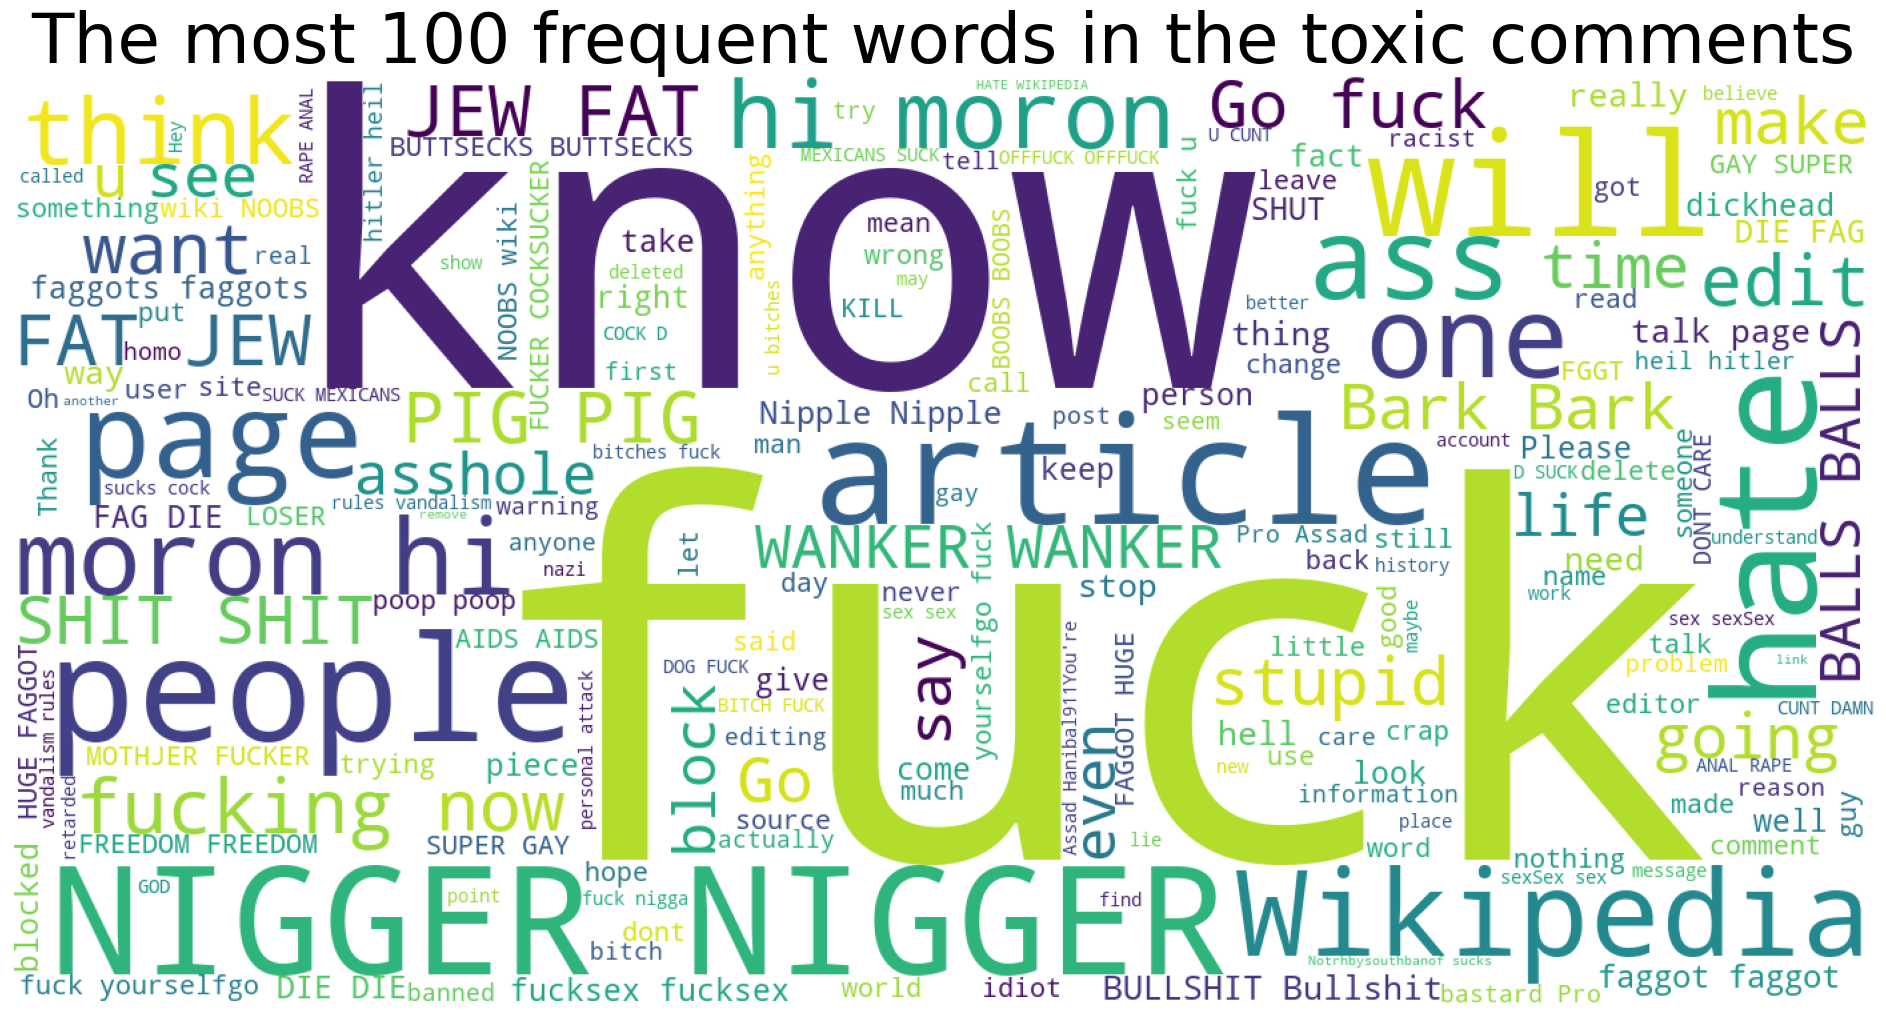

In [15]:
wordcloud = WordCloud(width=1400, height=700, background_color='white').generate(' '.join(toxic.text.tolist()))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The most 100 frequent words in the toxic comments', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

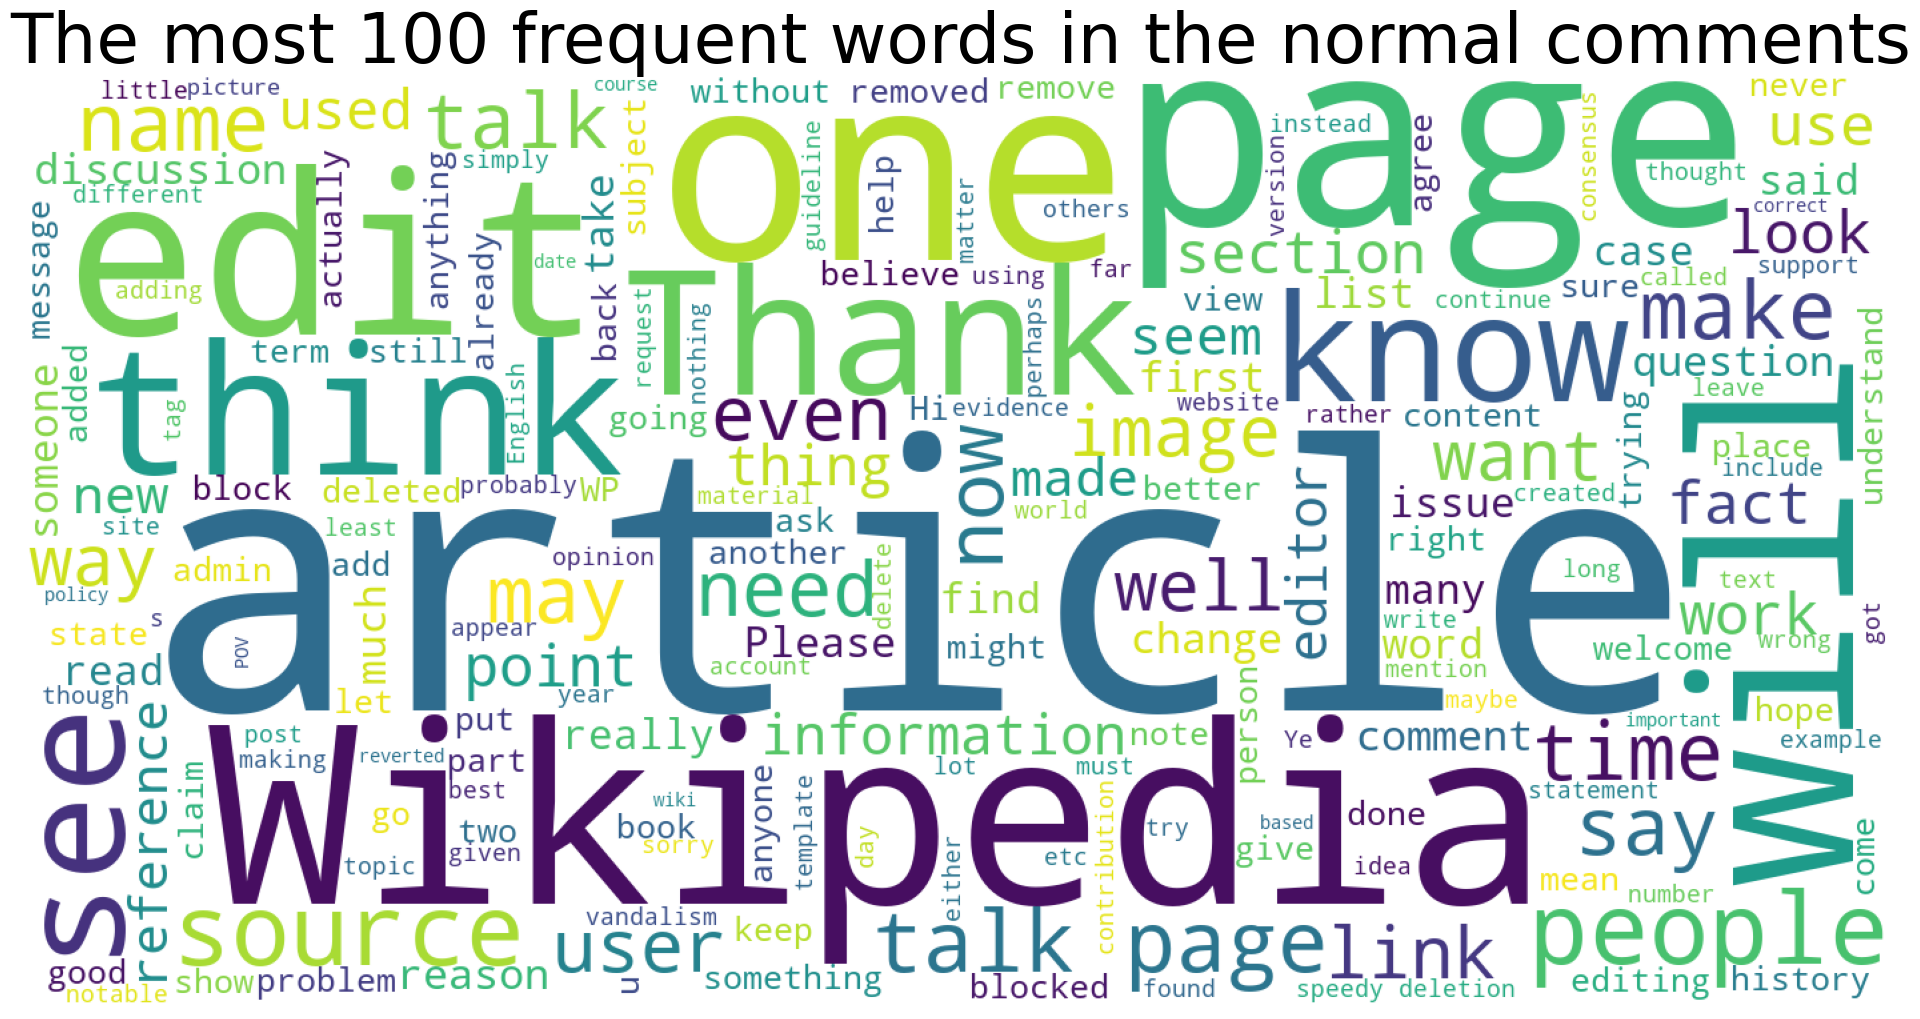

In [16]:
wordcloud = WordCloud(width=1400, height=700, background_color='white').generate(' '.join(not_toxic.text.tolist()))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The most 100 frequent words in the normal comments', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

In [17]:
y = dff.toxicity
x = dff.drop('toxicity', axis = 1)

In [18]:
texts = x.copy()
texts.reset_index(inplace = True, drop = True)
texts.head()

,text
0,The date connection was also referenced on tel...
1,Kevin Church A tag has been placed on Kevin C...
2,mONKeyS aLSO liKE tO fEeL yOU uP WHEN YOUR SLE...
3,fuck you jzg i will have you removed as edit...
4,Yoyoyo say what you want.


In [19]:
print(sys.getrecursionlimit())

3000


In [20]:
sys.setrecursionlimit(6000)

In [21]:
ps = PorterStemmer()
corpus = []

for i in tqdm(range(0, len(texts))) :
    cleaned = re.sub('[^a-zA-Z]', ' ', texts['text'][i])
    cleaned = cleaned.lower().split()
    
    cleaned = [ps.stem(word) for word in cleaned if not word in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

100%|██████████| 32450/32450 [05:43<00:00, 94.43it/s]


In [22]:
DIM = 100

X = [d.split() for d in corpus]
w2v_model = gensim.models.Word2Vec(sentences = X, vector_size = DIM, window = 10, min_count = 1)

In [23]:
len(w2v_model.wv.key_to_index.keys()) 

46216

In [24]:
w2v_model.wv.most_similar('toxic')

[('healthi', 0.9556636214256287),
 ('interfer', 0.9553321003913879),
 ('biznitch', 0.9550497531890869),
 ('envis', 0.9520622491836548),
 ('deepli', 0.9504584670066833),
 ('strip', 0.9498330354690552),
 ('vomit', 0.9495689868927002),
 ('securityfuck', 0.9494817852973938),
 ('calf', 0.9483137130737305),
 ('fade', 0.9475693702697754)]

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X) 

In [26]:
X = tokenizer.texts_to_sequences(X)
X[:3]

[[353, 925, 32, 1115, 2315, 12970, 487, 22742, 172, 1456, 36],
 [3143,
  873,
  156,
  95,
  3143,
  873,
  208,
  1470,
  15,
  4,
  164,
  2,
  96,
  34,
  309,
  17,
  457,
  1069,
  512,
  630,
  147,
  603,
  192,
  191,
  23,
  348,
  191,
  603,
  192,
  2,
  191,
  57,
  978,
  156,
  16,
  146,
  333,
  3,
  151,
  162,
  2,
  7,
  3,
  250,
  405,
  16,
  40,
  329,
  15,
  156,
  16,
  67,
  489,
  329,
  15,
  374,
  2,
  231,
  824,
  489,
  134,
  179,
  151,
  162,
  7,
  3,
  80,
  7,
  510],
 [1471,
  32,
  5,
  134,
  2059,
  7986,
  22743,
  12971,
  290,
  635,
  1471,
  22744,
  16041,
  173,
  1329,
  6160,
  37,
  22745,
  12972,
  1175,
  771,
  1471,
  31,
  878,
  3626]]

In [27]:
X = pad_sequences(X, padding = 'pre', maxlen = 20)
X[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
          353,   925,    32,  1115,  2315, 12970,   487, 22742,   172,
         1456,    36],
       [  156,    16,    67,   489,   329,    15,   374,     2,   231,
          824,   489,   134,   179,   151,   162,     7,     3,    80,
            7,   510],
       [ 7986, 22743, 12971,   290,   635,  1471, 22744, 16041,   173,
         1329,  6160,    37, 22745, 12972,  1175,   771,  1471,    31,
          878,  3626]], dtype=int32)

In [28]:
vocab_size = len(tokenizer.word_index) + 1 
vocab = tokenizer.word_index

In [29]:
def get_weights_matrix(model) :
    weights_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items() :
        weights_matrix[i] = model.wv[word]
        
    return weights_matrix


embedding_vectors = get_weights_matrix(w2v_model)

In [30]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = 20)) 
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))

In [31]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           4621700   
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

es = EarlyStopping(patience=3, 
                   monitor='loss', 
                   restore_best_weights=True, 
                   mode='min', 
                   verbose=1)

# train the model 
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 15,
                 callbacks=es, batch_size = 32, shuffle=True)

Epoch 1/15
812/812 [==============================] - 43s 49ms/step - loss: 0.1240 - accuracy: 0.8402 - val_loss: 0.1001 - val_accuracy: 0.8710
Epoch 2/15
812/812 [==============================] - 39s 48ms/step - loss: 0.0868 - accuracy: 0.8941 - val_loss: 0.0791 - val_accuracy: 0.8924
Epoch 3/15
812/812 [==============================] - 37s 46ms/step - loss: 0.0599 - accuracy: 0.9294 - val_loss: 0.0864 - val_accuracy: 0.8901
Epoch 4/15
812/812 [==============================] - 45s 55ms/step - loss: 0.0386 - accuracy: 0.9571 - val_loss: 0.0867 - val_accuracy: 0.8894
Epoch 5/15
812/812 [==============================] - 46s 57ms/step - loss: 0.0295 - accuracy: 0.9669 - val_loss: 0.0889 - val_accuracy: 0.8860
Epoch 6/15
812/812 [==============================] - 42s 52ms/step - loss: 0.0225 - accuracy: 0.9767 - val_loss: 0.0916 - val_accuracy: 0.8904
Epoch 7/15
812/812 [==============================] - 41s 51ms/step - loss: 0.0203 - accuracy: 0.9787 - val_loss: 0.0977 - val_accuracy:

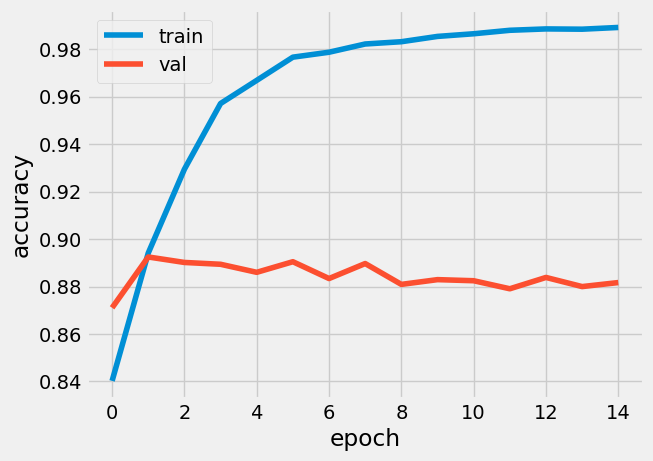

In [33]:
plt.style.use('fivethirtyeight')

# visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [34]:
sub = pd.read_csv("/kaggle/input/dataset/comments_to_score.csv")

In [35]:
new_text = tokenizer.texts_to_sequences(sub.text)
new_text = pad_sequences(new_text, maxlen = 20)

In [36]:
sub['score'] = model.predict(new_text) * 1000 
sub.head()

236/236 [==============================] - 2s 5ms/step


,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether ther...",981.971436
1,732895,"Looks like be have an abuser , can you please ...",983.877930
2,1139051,I confess to having complete (and apparently b...,-11.624784
3,1434512,"""\n\nFreud's ideas are certainly much discusse...",976.768494
4,2084821,It is not just you. This is a laundry list of ...,979.642334


In [37]:
sub[['comment_id', 'score']].to_csv("submission.csv", index=False)